# Random Forests Explained
### Jeanine Buyck

This is the code that was used for illustration purposes in the `TODO insert title and link` article.
Note that even after a few refactoring sessions, there is still quite a bit of duplicated code.
In practice, this notebook would likely get refactored further.
However, since the aim here is to clearly demonstrate what is happening at each step,
I'm choosing to leave some redundancy in hopes that it will make for easier reading.

## Generate synthetic data for use in examples

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt

from math import pi, sqrt, ceil
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

In [2]:
# custom modules

# this adds the parent dir to the path so we can import its modules
import sys
sys.path.insert(0,'..')

# this is how we'll generate data for our example
from synthetic_data.generate import sine_data

In [3]:
# set some controls for plots throughout the notebook
default_data_color = 'gray'
default_data_alpha = .5
default_data_size = 50
default_line_color = 'navy'
default_dpi = 300
print_title = False
save_image = True

# define some functions for recurring plots and model calls
def plot_training_data(X, y):
    """Plot the training data in a scatter."""
    plt.scatter(
        X,
        y,
        alpha=default_data_alpha,
        c=default_data_color,
        s=default_data_size
    )


def tree_fit(X, y, model):
    """Gets predictions from model given input X."""
    # transform shape of X to be what sklearn expects
    X_prepped = X.reshape(-1, 1)
    
    # fit the model
    model.fit(X_prepped, y)

    
def tree_predict(X, model):
    """Gets predictions from model given input X."""
    # transform shape of X to be what sklearn expects
    X_prepped = X.reshape(-1, 1)
    
    # get predictions
    y_hat = model.predict(X_prepped)
    
    return y_hat


def plot_model_results(X, y_hat,  c=default_line_color, label=None, legend_line_size=0):
    """Plots the results of a model as a line."""
    plt.plot(X, y_hat, c=c, label=label)
    plt.legend(
        handlelength=legend_line_size,  # controls length of colored line in legend
        frameon=False,  # toggles frame around legend on or off
        fontsize=12
    )

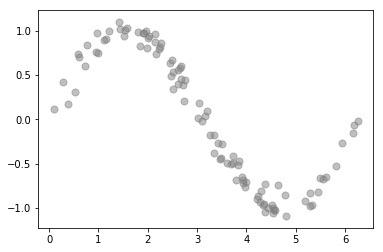

In [4]:
# set range of x-values for our demonstration
min_x = 0
max_x = 2 * pi

# generate synthetic data based on sine function
X, y = sine_data(
    min_x=min_x,
    max_x=max_x,
    n=100,
    amplitude=1,
    error_mean=0,
    error_std_dev=0.1
)

# plot the data we just created
plot_training_data(X, y)
if print_title:
    plt.title('The Training Data')
if save_image:
    plt.savefig('training_data.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

In [5]:
# generate some x-values for plotting models later on
X_model_plot = np.linspace(min_x, max_x, num=10_000, endpoint=True)

## Build a few decision trees of various depths

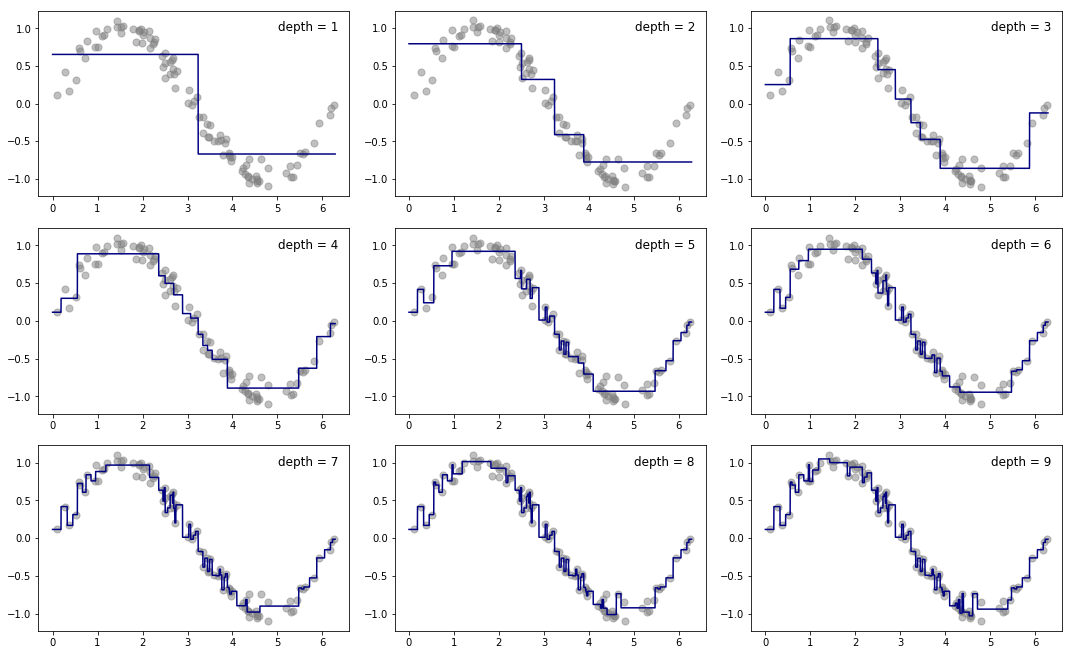

In [6]:
# this controls how many trees we'll build
tree_count = 9

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(tree_count))

# we're going to build a total of num_trees, each at increasing depth
for depth in range(tree_count):
    # grow a tree and get its depth
    max_depth = depth + 1  # off by one due to range behavior
    single_tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    tree_fit(X, y, single_tree)
    tree_depth = single_tree.get_depth()
    
    # create our subplot and plot our training data
    plt.subplot(subplot_dim, subplot_dim, max_depth)
    plot_training_data(X, y)

    # generate the predictions for plotting the model
    y_model_plot = tree_predict(X_model_plot, single_tree)
    
    # plot each tree's predictions
    plot_model_results(
        X=X_model_plot,
        y_hat=y_model_plot,
        label=f'depth = {tree_depth}'
    )
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# final touches on our plot and saving to file
if print_title:
    plt.suptitle('Individual Decision Trees at Various Depths', fontsize=18)
if save_image:
    plt.savefig(f'{tree_count}_single_trees_diff_depths.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

## Define some functions and constants to help us with our ensembles

In [7]:
# Note that in practice, these functions should live in a module outside of this notebook.
# For ease of demonstration, they are being defined here so the reader doesn't need to
# leave the notebook while following through the expamples.

def ensemble_grow(X, y, num_trees, max_depth, bootstrap=False):
    """
    Grows num_trees individual decision trees, each with max depth of max_depth,
    and returns a list of the trained trees.
    
    Default behavior is to use the full data set (X and y) to grow each tree.
    That is, each tree is grown on the same set of data, X and y.
    
    If bootstrap is set to `True`, then a bootstrapped sample of X and y is used
    to train each tree. That is, each tree is grown on its own bootstrapped sample
    of the data, where the sample is that same size as the original X and y.
    """
    
    # this list will hold the trees we train
    trees = []
    
    for tree in range(num_trees):
        if bootstrap:
            # default behavior of `resample` is to return a sample with same size as input
            train_X, train_y = resample(X, y, replace=True)
        else:
            # just use the input X and y to train the tree
            train_X, train_y = X, y
        
        ensemble_tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
        tree_fit(train_X, train_y, ensemble_tree)
        
        trees.append(ensemble_tree)
        
    return trees


def ensemble_predict(X, trees):
    """Get predictions for X by averaging predictions from the trees."""
    
    # keep track of number of trees for computing the average later
    num_trees = len(trees)
    
    # start with zeros, we will add predictions to this for each tree
    y_hat_sum = np.zeros(len(X))
    
    # get the predictions for each tree and add to running sum
    for tree in trees:
        y_hat_sum += tree_predict(X, tree)
        
    # divide by total number of trees to get the average
    y_hat = y_hat_sum / num_trees
    
    return y_hat


# constants
num_trees=6
max_depth=4

## Build an ensemble of trees with the same max_depth, no randomness added in.

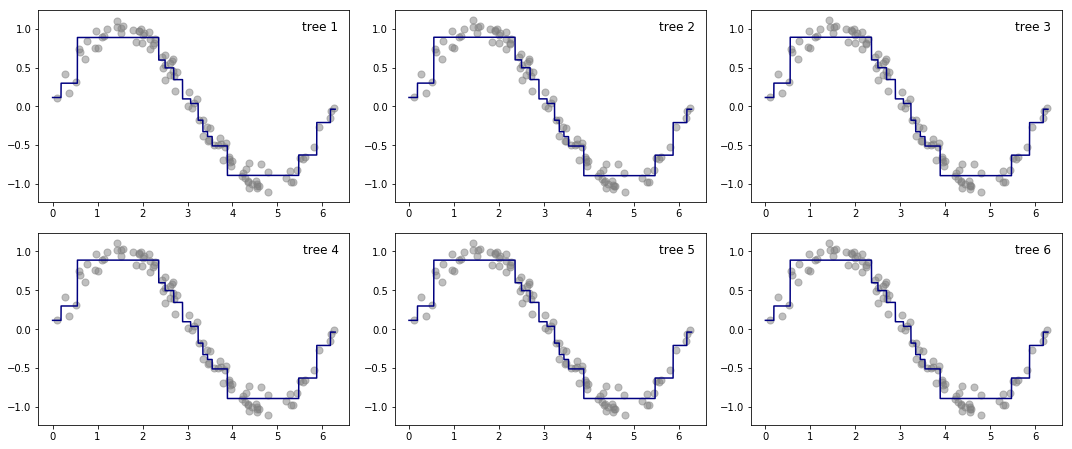

In [8]:
# create an ensemble of trees with no randomness added in
ensemble_deterministic = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees, 
    max_depth=max_depth,
    bootstrap=False
)    

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(num_trees))

# plot the model for each tree in the ensemble on its own graph
for idx, tree in enumerate(ensemble_deterministic):
    tree_depth = tree.get_depth()
    
    # create our subplot and plot our training data
    plt.subplot(subplot_dim, subplot_dim, idx+1)
    plot_training_data(X, y)
    
    # generate the predictions for plotting the model
    y_model_plot = tree_predict(X_model_plot, tree)

    # plot each tree's predictions
    plot_model_results(
        X=X_model_plot,
        y_hat=y_model_plot,
        label=f'tree {idx + 1}'
    )
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# final touches on our plot and saving to file
if print_title:
    plt.suptitle('Individual Trees in Ensemble', fontsize=18)
if save_image:
    plt.savefig('trees_in_determinisic_ensemble.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

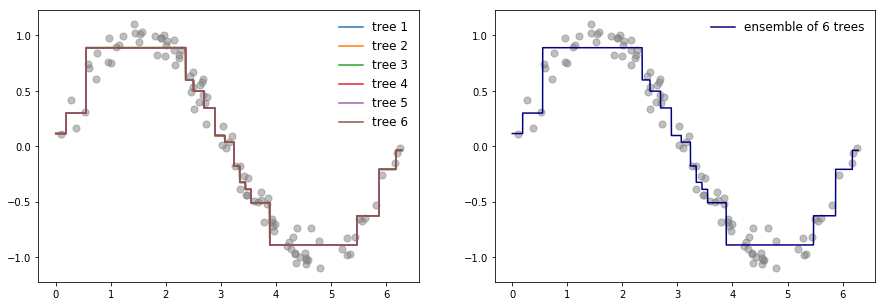

In [9]:
# plot side by side: all decision tree models on one graph, next to the ensemble on another
# GOAL: show without bootstrapping we have not changed the model results

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 5))

# plot the model for each tree within the ensemble on the same graph
plt.subplot(1, 2, 1)
if print_title:
    plt.title(f'Individual Decision Trees', fontsize=14)
    
# plot our training data
plot_training_data(X, y)

for idx, tree in enumerate(ensemble_deterministic):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree_predict(X_model_plot, tree)
    
    # plot each tree's predictions
    plot_model_results(
        X=X_model_plot,
        y_hat=y_model_plot,
        c=None,
        label=f'tree {idx + 1}',
        legend_line_size=2
    )

# plot the results of ensemble on another graph
plt.subplot(1, 2, 2)
if print_title:
    plt.title(f'An Ensemble of Trees', fontsize=14)

# plot our training data
plot_training_data(X, y)

# generate the predictions for plotting the model
y_model_plot = ensemble_predict(X_model_plot, ensemble_deterministic)

# plot the ensemble's predictions
plot_model_results(
    X=X_model_plot,
    y_hat=y_model_plot,
    label=f'ensemble of {num_trees} trees',
    legend_line_size=2
)

# final touches on our plot and saving to file
if save_image:
    plt.savefig('determinisic_ensemble_side_by_side.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

## Build an ensemble of trees with the same max_depth, but bootstrap the training data.

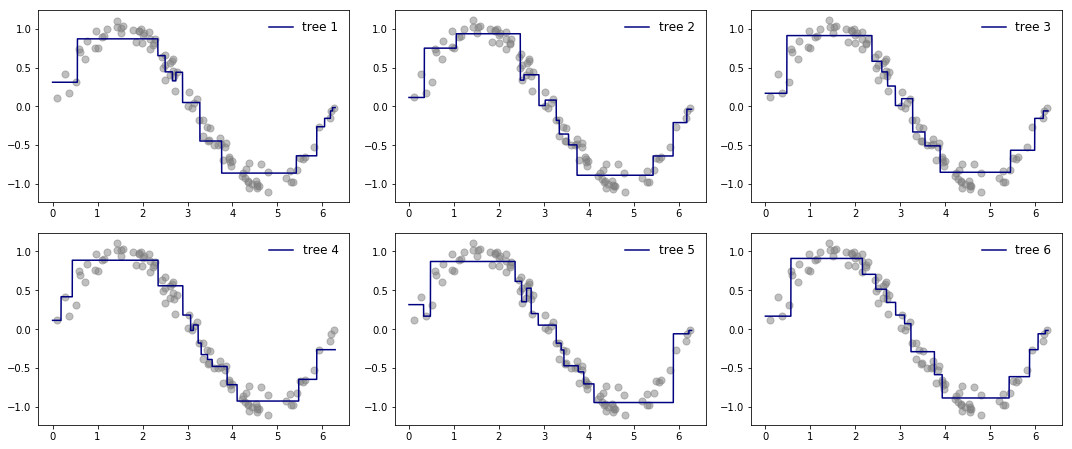

In [10]:
# create an ensemble of trees with bootstrapped training sets
ensemble_bootstrapped = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees, 
    max_depth=max_depth,
    bootstrap=True
)    

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 10))

# get number of rows and cols for subplot to plot in a square grid
subplot_dim = ceil(sqrt(num_trees))

# plot the model for each tree in the ensemble on its own graph
for idx, tree in enumerate(ensemble_bootstrapped):
    tree_depth = tree.get_depth()
    
    # create our subplot and plot our training data
    plt.subplot(subplot_dim, subplot_dim, idx+1)
    plot_training_data(X, y)
    
    # generate the predictions for plotting the model
    y_model_plot = tree_predict(X_model_plot, tree)
    
    # plot each tree's predictions
    plot_model_results(
        X=X_model_plot,
        y_hat=y_model_plot,
        label=f'tree {idx + 1}',
        legend_line_size=2
    )
    
    # this keeps the plot margins tight, without messing up the suptitle! see top answer at:
    # https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# final touches on our plot and saving to file
if print_title: 
    plt.suptitle('Individual Trees in Ensemble with Bootstrapping', fontsize=18)
if save_image:
    plt.savefig('trees_in_bootstrapped_ensemble.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

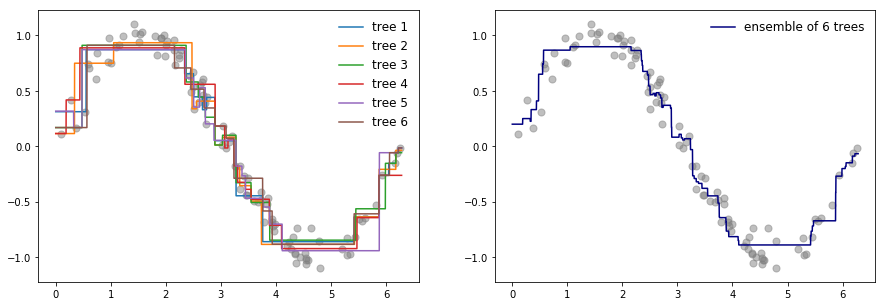

In [11]:
# plot side by side: all decision tree models on one graph, next to the ensemble on another
# GOAL: see that not only does the ensemble produce a different result,
#       but also the curve is becoming smoother and not overfitting the data.

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 5))

# plot the model for each tree within the ensemble on the same graph
plt.subplot(1, 2, 1)
if print_title:
    plt.title(f'Individual Decision Trees with Bootstrapping', fontsize=14)

# plot our training data
plot_training_data(X, y)

for idx, tree in enumerate(ensemble_bootstrapped):
    tree_depth = tree.get_depth()
    
    # generate the predictions for plotting the model
    y_model_plot = tree_predict(X_model_plot, tree)
    
    # plot each tree's predictions
    plot_model_results(
        X=X_model_plot,
        y_hat=y_model_plot,
        c=None,
        label=f'tree {idx + 1}',
        legend_line_size=2
    )

# plot the results of ensemble on another graph
plt.subplot(1, 2, 2)
if print_title:
    plt.title(f'An Ensemble of Trees with Bootstrapping', fontsize=14)

# plot our training data
plot_training_data(X, y)

# generate the predictions for plotting the model
y_model_plot = ensemble_predict(X_model_plot, ensemble_bootstrapped)

# plot the ensemble's predictions
plot_model_results(
    X=X_model_plot,
    y_hat=y_model_plot,
    label=f'ensemble of {num_trees} trees',
    legend_line_size=2
)

# final touches on our plot and saving to file
if save_image:
    plt.savefig('bootstrapped_ensemble_side_by_side.png', dpi=default_dpi, bbox_inches='tight')
plt.show()

## Show that a random forest _can_ overfit the data

In [12]:
# start with random forest from above and do two variations
# 1. let number of decision trees increase dramatically, but keep max_depth fixed and small
# 2. keep number of decision trees fixed, but let max_depth get big

# GOAL: show that increasing the number of trees does not overfit the data but does smooth the curve
#       AND that averaging is not enough to correct for overfitting if the individual trees are too deep

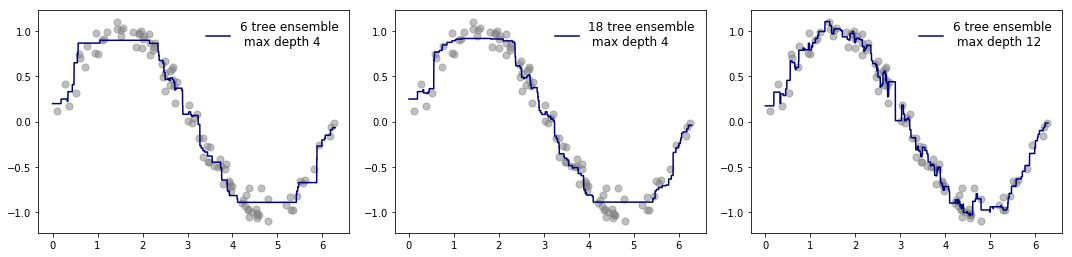

In [13]:
# set a factor for making the number of trees or max depth larger
scaling_factor = 3

# figure size to keep all of the subplots legible
plt.figure(figsize=(15, 4))

# Part 0: plot our previous ensemble for easy reference
plt.subplot(1, 3, 1)

if print_title:
    plt.title(f'A Random Forest {num_trees} Trees with Depth {max_depth}')

# plot our training data
plot_training_data(X, y)

# generate the predictions for plotting the model
y_model_plot = ensemble_predict(X_model_plot, ensemble_bootstrapped)

# plot the ensemble's predictions
plot_model_results(
    X=X_model_plot,
    y_hat=y_model_plot,
    label=f'{num_trees} tree ensemble\n max depth {max_depth}',
    legend_line_size=2
)

# Part 1: let number of decision trees increase dramatically, but keep max_depth fixed and small
plt.subplot(1, 3, 2)
    
more_trees = scaling_factor * num_trees
many_tree_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=more_trees,  # increase from previous tree count 
    max_depth=max_depth,   # leave max_depth fixed as in original
    bootstrap=True
)

if print_title:
    plt.title(f'A Random Forest of {more_trees} Trees with Depth {max_depth}')

# plot our training data
plot_training_data(X, y)

# generate the predictions for plotting the model
y_model_plot = ensemble_predict(X_model_plot, many_tree_ensemble)

# plot the ensemble's predictions
plot_model_results(
    X=X_model_plot,
    y_hat=y_model_plot,
    label=f'{more_trees} tree ensemble\n max depth {max_depth}',
    legend_line_size=2
)

# Part 2: keep number of decision trees fixed, but let max_depth get big
plt.subplot(1, 3, 3)
    
more_depth = scaling_factor * max_depth
deep_tree_ensemble = ensemble_grow(
    X=X, 
    y=y, 
    num_trees=num_trees,   # leave tree count fixed as in original
    max_depth=more_depth,  # increase from previous max_depth
    bootstrap=True
)

if print_title:
    plt.title(f'A Random Forest of {num_trees} Trees with Depth {more_depth}')

# plot our training data
plot_training_data(X, y)

# generate the predictions for plotting the model
y_model_plot = ensemble_predict(X_model_plot, deep_tree_ensemble)

# plot the ensemble's predictions
plot_model_results(
    X=X_model_plot,
    y_hat=y_model_plot,
    label=f'{num_trees} tree ensemble\n max depth {more_depth}',
    legend_line_size=2
)

# this keeps the plot margins tight, without messing up the suptitle! see top answer at:
# https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# final touches on our plot and saving to file
if save_image:
    plt.savefig('random_forest_num_trees_vs_depth.png', dpi=default_dpi, bbox_inches='tight')

plt.show()

## Compare our results to those from sci-kit learn's `RandomForestRegressor`

In [ ]:
# TODO code up a quick example of the above plot but using sci-kit learn's implementation instead